```text
=================================================

Computer Vision - Deep Learning

Created By  : Ahmad Naufal Budianto

=================================================
```

# Introduction

Sebuah instansi *fintech* India `RupeeLend` ingin membuat aplikasi digital terkait layanan Pinjaman Online, dalam aplikasi tersebut ingin dilakukannya verifikasi umur disaat pendaftaran awal, dimana yang diperbolehkan memiliki akun digital pada aplikasi `RupeeLend` hanyalah usia produktif (20-55 tahun).

Program ini dibuat untuk melakukan analisa pengelompokan wajah berdasarkan umur menggunakan Deep Learning (Computer Vision). Yang nantinya model Deep Learning ini akan digunakan sebagai **prototype pertama** aplikasi. Pada kasus ini dilakukan pelatihan pada dataset untuk menseleksi wajah dengan golongan umur **produktif** (`Young` & `Middle`) untuk dikategorikan sebagai class yang **dapat medaftar aplikasi**, dan mendeteksi wajah **non-produktif** (`Old`) untuk dikategorikan sebagai class yang **tidak diperbolehkan** mendaftar aplikasi.

Dataset yang digunakan pada pelatihan prototype pertama ini berupa hasil data scrapping wajah-wajah selebritis India (dimana market `RupeeLend` merupakan warga India), kedepannya hasil model ini akan dilatih dengan kualitas dataset yang lebih baik pada pengembangan prototype berikutnya (*transfer learning*).

--


Sumber Dataset: [File - faces](https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset)

Referensi Kasus: [Link 1](https://withpersona.com/blog/what-is-selfie-identity-verification-and-how-does-it-work), [Link 2](https://gritdaily.com/role-of-ai-in-facilitating-peer-to-peer-lending/)

*Note: Kasus di atas hanyalah fiktif, tidak ada instansi bernama RupeeLend.*

# Import Libraries

In [2]:
import os
import cv2
import glob
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Membuat hidden direktori `.kaggle`.
!mkdir ~/.kaggle

In [5]:
# Copy kaggle.json ke dalam direktori `.kaggle`.
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [6]:
# Source dataset : https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset
# Melakukan download dataset ke dalam drive.
%%time
!kaggle datasets download -d arashnic/faces-age-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/faces-age-detection-dataset
License(s): CC0-1.0
 82% 85.0M/104M [00:00<00:00, 201MB/s]
100% 104M/104M [00:00<00:00, 210MB/s] 
CPU times: user 18.1 ms, sys: 4.71 ms, total: 22.9 ms
Wall time: 2.11 s


In [7]:
# Melakukan unzip pada dataset dan disimpan ke drive.
!unzip /content/faces-age-detection-dataset.zip &> /dev/null

In [8]:
# Mendefinisikan path.
base_path = '/content/faces'
img_path = os.path.join(base_path, 'Train')
csv_path = os.path.join(base_path, 'train.csv')

In [9]:
dataset = pd.read_csv(csv_path)
dataset['Class'].value_counts()

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64

In [10]:
# Dikarenakan tiap class masih dalam satu folder yang sama, maka dibuatkan direktori baru berdasarkan tiap class.
classifications = ['YOUNG', 'MIDDLE', 'OLD']
for classification in classifications:
    os.makedirs(os.path.join(base_path, classification), exist_ok=True)

# Memindahkan gambar ke tiap direktori sesuai dengan data table.
for index, row in dataset.iterrows():
    img_id = row['ID']
    classification = row['Class']
    src = os.path.join(img_path, img_id)
    dst = os.path.join(base_path, classification, img_id)
    shutil.move(src, dst)

In [11]:
# Menghapus dataset awal agar tidak terjadi kebingungan pada path base_dir.
shutil.rmtree('/content/faces/Train')
os.remove('/content/faces/train.csv')

In [12]:
# Melakukan definisi path direktori tiap class.
old_dir = '/content/faces/OLD'
young_dir = '/content/faces/YOUNG'
middle_dir = '/content/faces/MIDDLE'

In [13]:
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

old_count = count_files(old_dir)
young_count = count_files(young_dir)
middle_count = count_files(middle_dir)


print(f"Jumlah gambar pada direktori 'YOUNG': {young_count}")
print(f"Jumlah gambar pada direktori 'MIDDLE': {middle_count}")
print(f"Jumlah gambar pada direktori 'OLD': {old_count}")

Jumlah gambar pada direktori 'YOUNG': 6706
Jumlah gambar pada direktori 'MIDDLE': 10804
Jumlah gambar pada direktori 'OLD': 2396


# A. EDA

Pada tahap ini akan dilakukan 5 analisa utama pada data gambar terkait bentuk dan warna, ukuran gambar, ruang warna, angle gambar, dan karakteristik lainnya.



## Shape and Colours

In [14]:
# Mendefinisikan fungsi untuk menampilkan 5 gambar random dari direktori.
def display_random_images(directory, title):
    all_images = os.listdir(directory)
    random_images = random.sample(all_images, 5)

    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize=16)

    for i, image_name in enumerate(random_images):
        img_path = os.path.join(directory, image_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(image_name)

    plt.show()

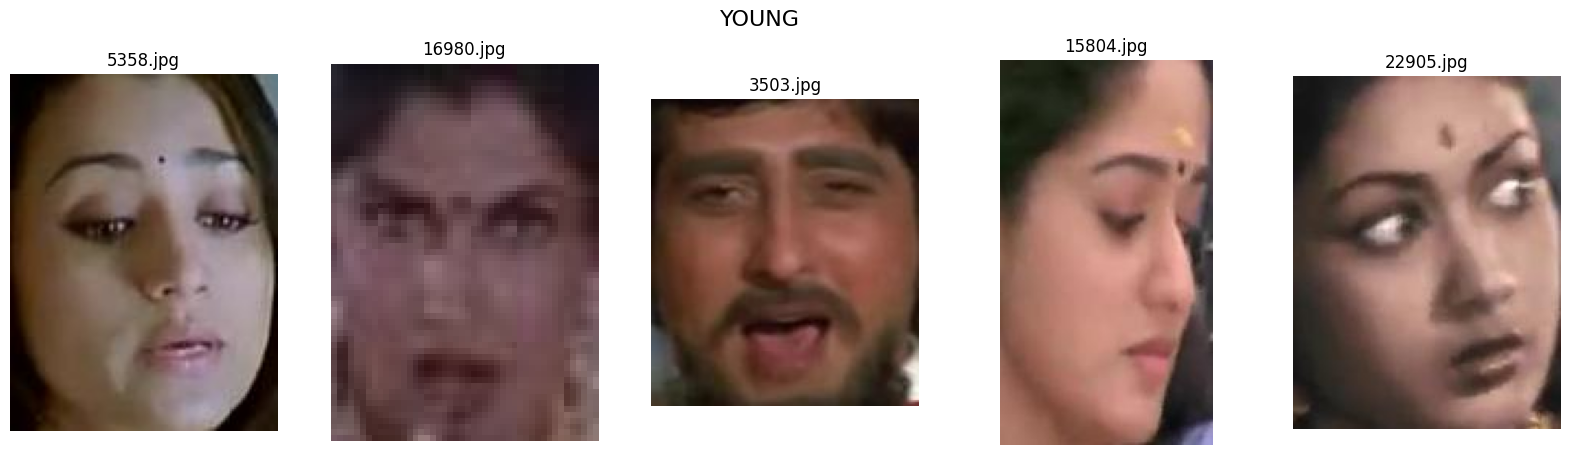

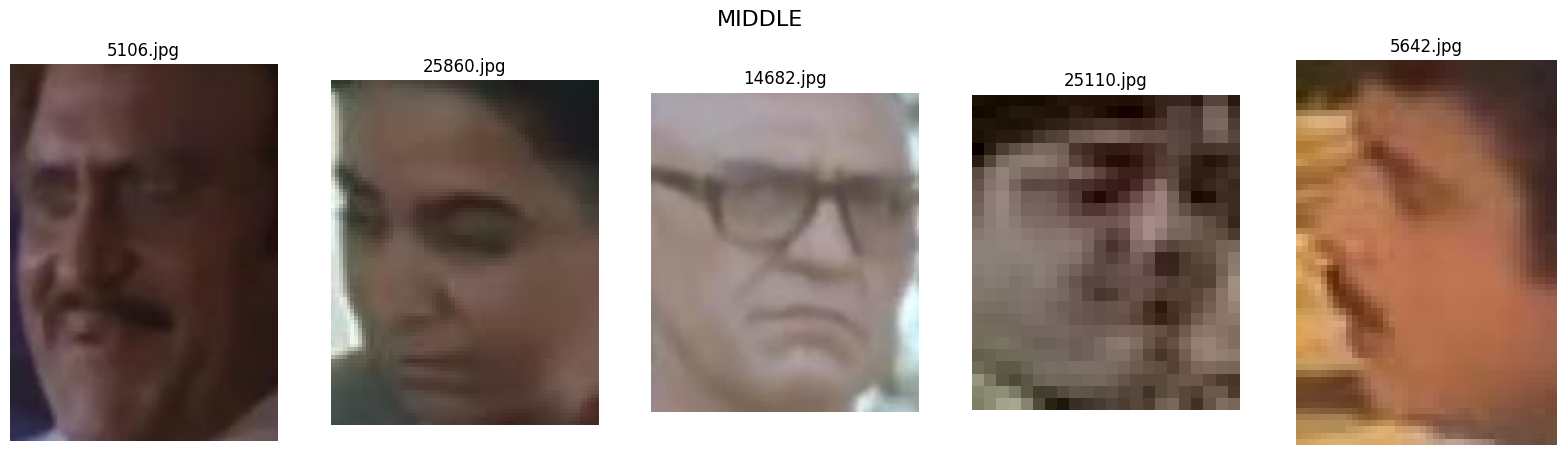

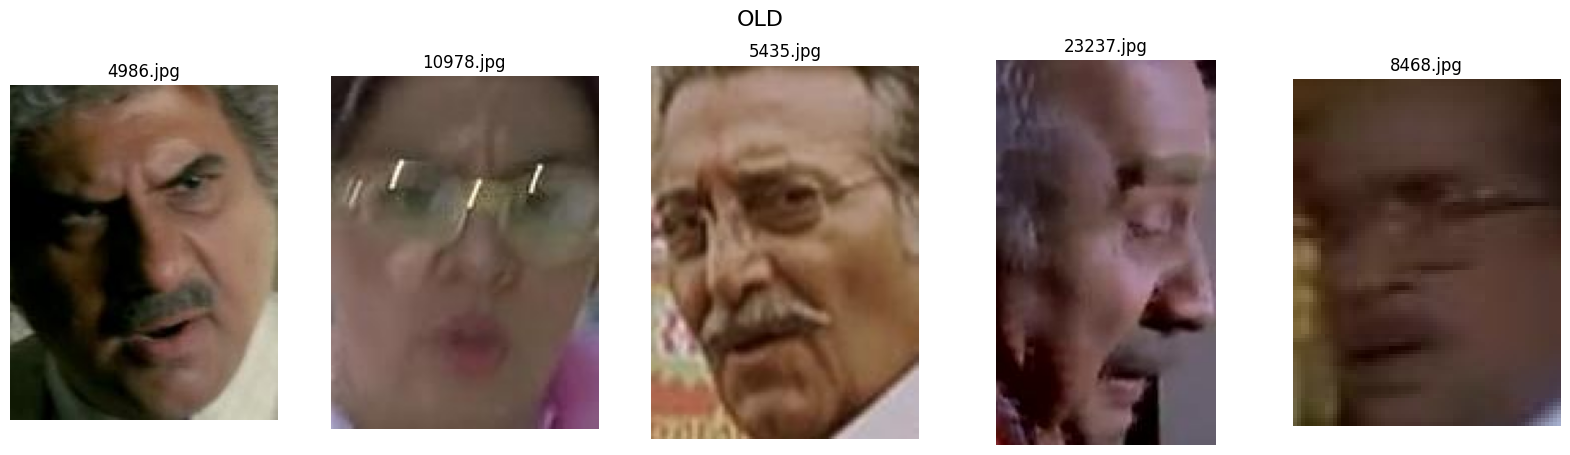

In [15]:
# Direktori yang ingin ditampilkan.
display_random_images(young_dir, 'YOUNG')
display_random_images(middle_dir, 'MIDDLE')
display_random_images(old_dir, 'OLD')

Meskipun gambar-gambar di atas sudah terfokus (sudah dilakukan crop) hanya pada wajah, tetapi tiap kelas terdapat banyak gambar yang kurang baik (pecah/terlalu kecil), sehingga nanti nya pada tahap eksplorasi ukuran gambar akan saya seleksi pada ukuran tertentu agar didapatkan dataset yang lebih baik.

Untuk analisa warna gambar pada dataset, dikarenakan dataset berisikan gambar-gambar selebritis India, maka warna dari dataset didominasi oleh warna kulit kuning dan sawo matang. **Namun** ada juga beberapa gambar berwarna hitam putih.

Adapun terkait bentuk dari gambar tiap kelas, meskipun gambar sudah terfokus hanya pada wajah, namun terdapat beberapa riasan/atribut upacara adat dan pentas pada gambar. Seperti surban, kacamata, dan lainnya. Dan adanya inkonsistensi ekspresi pada wajah di tiap class, seperti tertawa, berteriak, dan lain-lain.

## Image Sizes

Ketika dilakukan cek manual kasat mata pada dataset gambar, saya menemukan beberapa gambar yang terlalu kecil dan tidak layak untuk dimasukkan ke dalam program pelatihan. Dan rata-rata gambar yang tidak layak tersebut berukuran kurang dari `2,5KB`, maka pada tahap ini saya akan melakukan filtering gambar dengan ukuran tersebut.

In [16]:
# Definisi fungsi untuk mengapus gambar-gambar dengan ukuran kurang dari 2.5KB.
def remove_small_files(directory, min_size_kb=2.5):
    min_size_bytes = min_size_kb * 1024  # Konversi ke bytes
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            file_size = os.path.getsize(file_path)
            if file_size < min_size_bytes:
                os.remove(file_path)

# Definisi fungsi untuk menghitung jumlah gambar tiap direktori.
def count_files(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Mengaplikasikan fungsi penghapusan gambar.
remove_small_files(old_dir)
remove_small_files(young_dir)
remove_small_files(middle_dir)

# Menghitung jumlah gambar tiap direktori setelah dihapus.
old_count = count_files(old_dir)
young_count = count_files(young_dir)
middle_count = count_files(middle_dir)

In [17]:
# Menampilkan jumlah gambar tiap direktori setelah dihapus.
print(f"Jumlah gambar final di direktori YOUNG: {young_count}")
print(f"Jumlah gambar final di direktori MIDDLE: {middle_count}")
print(f"Jumlah gambar final di direktori OLD: {old_count}")

Jumlah gambar final di direktori YOUNG: 2498
Jumlah gambar final di direktori MIDDLE: 2936
Jumlah gambar final di direktori OLD: 656


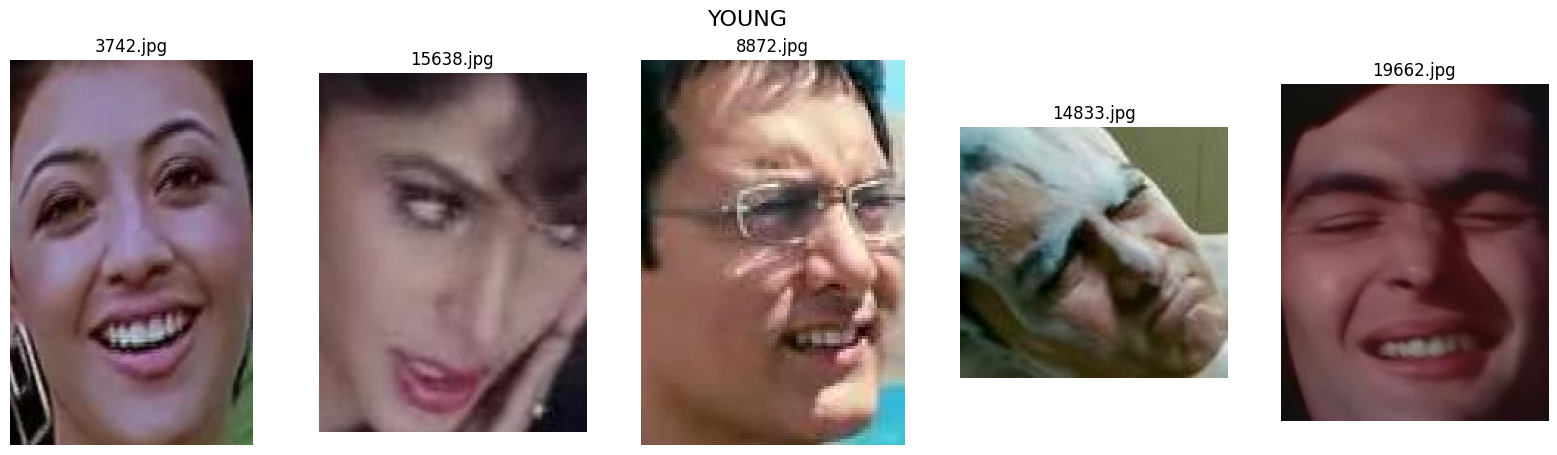

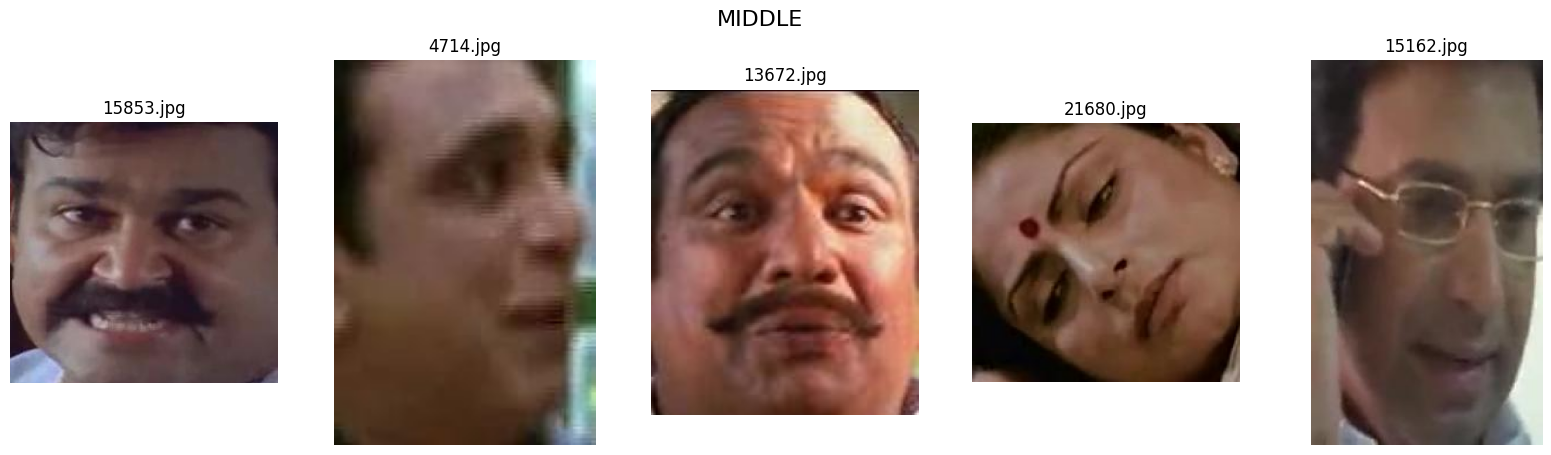

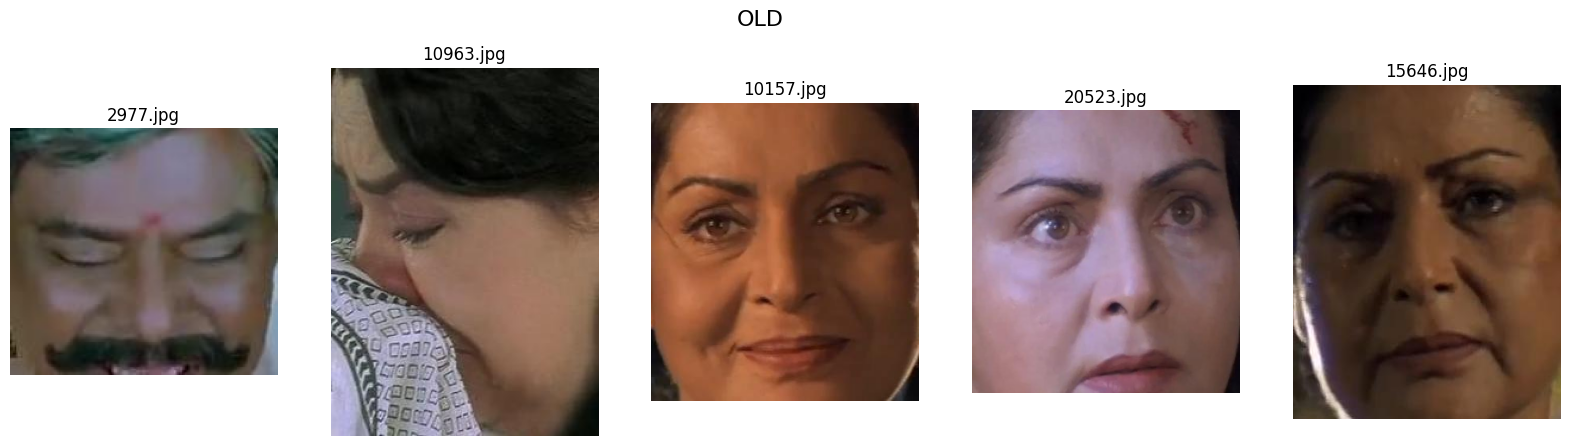

In [18]:
# Menampilkan gambar random tiap direktori setelah dibersihkan.
display_random_images(young_dir, 'YOUNG')
display_random_images(middle_dir, 'MIDDLE')
display_random_images(old_dir, 'OLD')

Terlihat setelah dilakukan pembersihan pada ukuran gambar pada tiap class, tampak gambar lebih konsisten dari segi kejelasan gambarnya.

## Room of Colour



Berdasarkan beberapa referensi penelitian sebelumnya yang saya baca:
* [link 1](https://www.researchgate.net/publication/283185121_Comparative_Study_of_Skin_Color_Detection_and_Segmentation_in_HSV_and_YCbCr_Color_Space),
* [link 2](https://link.springer.com/chapter/10.1007/978-981-13-8676-3_58),
* [link 3](https://pdfs.semanticscholar.org/52fe/3af16b79c5d9a87b136b29e7cb3c646fb4fa.pdf),

Didapatkan bahwa program Computer Vision lebih efektif dan konsisten untuk mendeteksi warna alami kulit manusia dalam format ruang warna `YCbCr`. Sehingga pada proses ini saya akan melakukan konversi ruang warna pada tiap gambar ke dalam `YCbCr`.

In [19]:
# Membuat fungsi konversi ruang warna YCbCR.
def convert_images_to_ycbcr(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            try:
                image_rgb = cv2.imread(file_path)

                if image_rgb is None:
                    print(f"Error reading {file_path}")
                    continue

                # Melakukan konversi ruang warna.
                image_ycbcr = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2YCrCb)

                # Melakukan save overwrite.
                cv2.imwrite(file_path, image_ycbcr)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

convert_images_to_ycbcr(old_dir)
convert_images_to_ycbcr(young_dir)
convert_images_to_ycbcr(middle_dir)

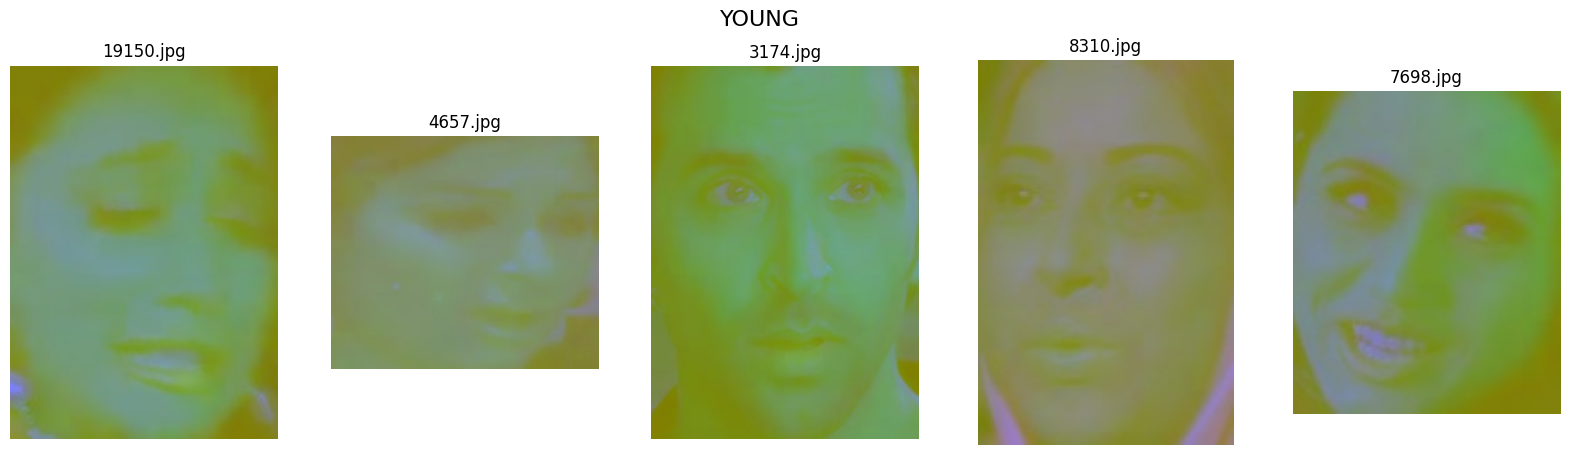

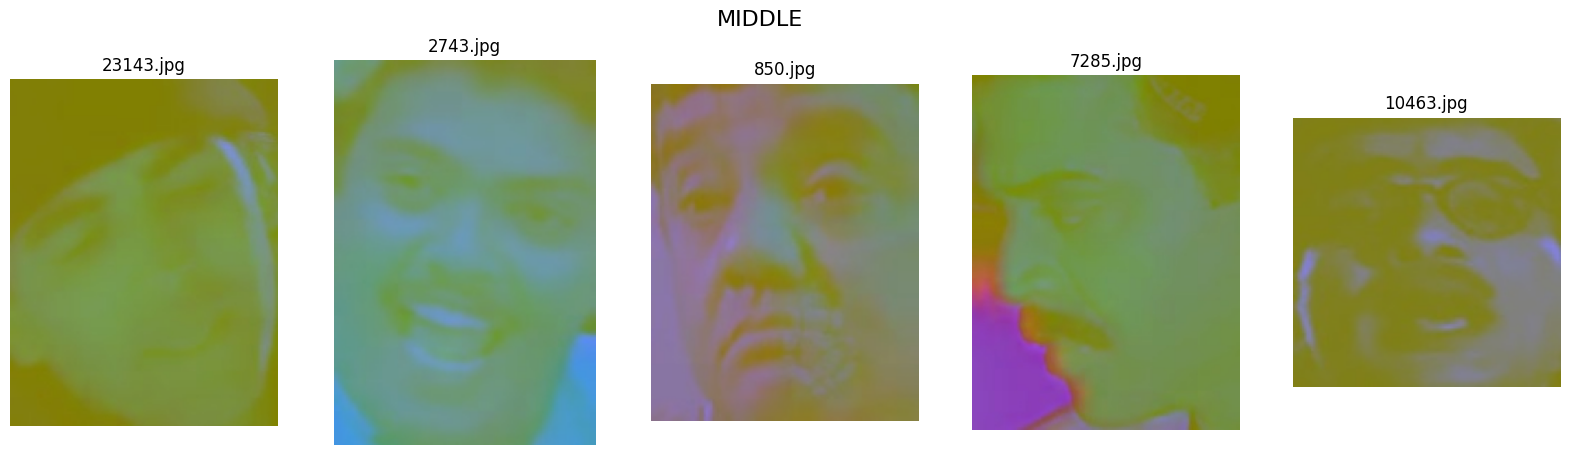

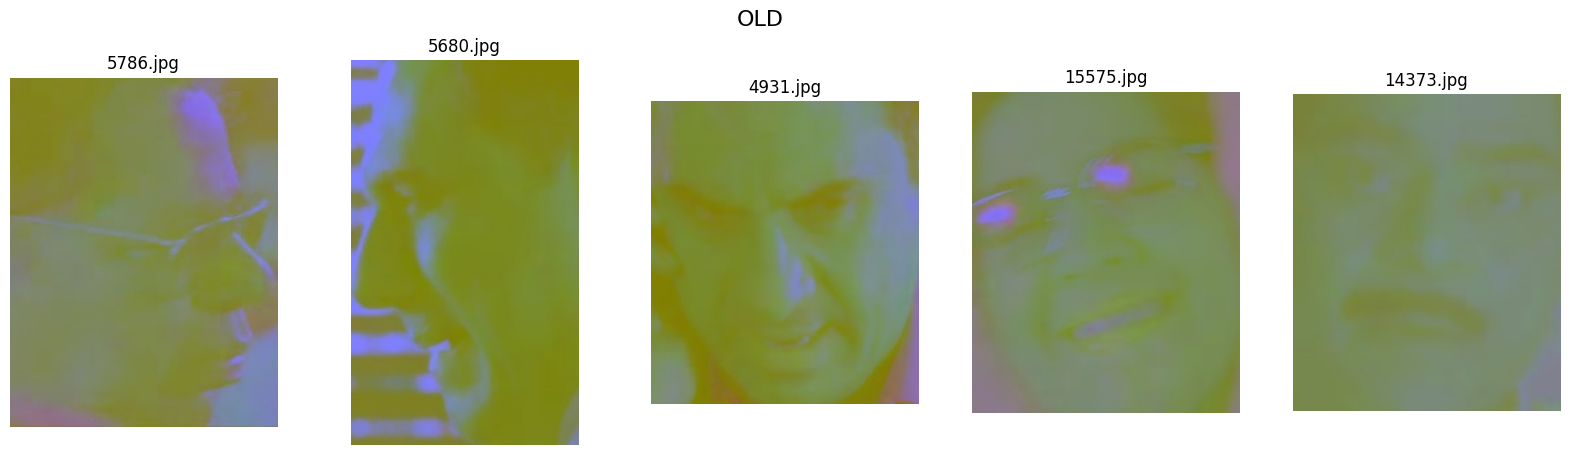

In [20]:
# Menampilkan gambar acak tiap class setelah dilakukan konversi YCbCR.
display_random_images(young_dir, 'YOUNG')
display_random_images(middle_dir, 'MIDDLE')
display_random_images(old_dir, 'OLD')

## Angle of the Images

Terlihat bahwa mayoritas gambar pada tiap class memiliki sudut foto yang tidak beraturan (menghadap samping, bawah, atau atas), menurut survey dilapangan dan [referensi](https://verihubs.com/blog/cara-selfie/) yang saya baca untuk melakukan *face recognition* pada aplikasi seharusnya gambar wajah yang diambil adalah simetris dengan wajah menghadap lurus ke depan. Akan tetapi karena keterbatasan kemampuan dan wawasan teknis yang saya miliki, maka saya tidak akan melakukan modifikasi gambar menjadi simetris dan menghadap lurus ke depan.


## Other Characteristics on Images




Seperti yang saya sampaikan di awal, pada gambar-gambar wajah terdapat riasan/atribut upacara adat/ibadah dan pesta. Seperti contoh surban, anting wajah, kacamata, riasan mencolok pada muka, dan lainnya. Hal ini terjadi pada tiap class image dataset yang dimiliki.

Akan tetapi dikarenakan keterbatasan sumber data dan waktu (untuk melakukan manual scanning/deletion), maka saya memutuskan untuk tidak melakukan penanangan apapun terhadap foto wajah yang memiliki karakter-karakter lain selain unsur alami pada wajah. Terlebih dikarekan ini adalah prototype pertama, maka program ini dibuat se-efisien mungkin.

# B. Data Preprocessing

In [21]:
# Melakukan listing gambar pada tiap class.

young_files = glob.glob('/content/faces/YOUNG/*')
middle_files = glob.glob('/content/faces/MIDDLE/*')
old_files = glob.glob('/content/faces/OLD/*')

young_files.sort()
middle_files.sort()
old_files.sort()

all_files = old_files + young_files + middle_files
labels = ['Old' for i in range(len(old_files))] + ['Young' for i in range(len(young_files))] + ['Middle' for i in range(len(middle_files))]
img_dataset = pd.DataFrame({'images':all_files, 'label':labels})

img_dataset = img_dataset.sample(frac=1).reset_index(drop=True)
img_dataset.head(25)

images   label
0    /content/faces/MIDDLE/1753.jpg  Middle
1      /content/faces/OLD/18605.jpg     Old
2   /content/faces/MIDDLE/22717.jpg  Middle
3    /content/faces/MIDDLE/4853.jpg  Middle
4       /content/faces/OLD/6073.jpg     Old
5    /content/faces/MIDDLE/9734.jpg  Middle
6    /content/faces/YOUNG/12113.jpg   Young
7      /content/faces/OLD/15524.jpg     Old
8    /content/faces/YOUNG/18686.jpg   Young
9     /content/faces/YOUNG/1662.jpg   Young
10   /content/faces/MIDDLE/4681.jpg  Middle
11   /content/faces/YOUNG/16333.jpg   Young
12     /content/faces/OLD/10896.jpg     Old
13   /content/faces/MIDDLE/4030.jpg  Middle
14  /content/faces/MIDDLE/25536.jpg  Middle
15  /content/faces/MIDDLE/16148.jpg  Middle
16  /content/faces/MIDDLE/19552.jpg  Middle
17  /content/faces/MIDDLE/20643.jpg  Middle
18   /content/faces/MIDDLE/3341.jpg  Middle
19  /content/faces/MIDDLE/14145.jpg  Middle
20   /content/faces/YOUNG/13984.jpg   Young
21    /content/faces/MIDDLE/760.jpg  Middle
22  /content/faces/MIDDLE/18249.jpg  Middle
23  /content/faces/MIDDLE/22019.jpg  Middle
24  /content/faces/MIDDLE/26240.jpg  Middle

# C. Feature Engineering

In [22]:
# Melakukan data augmentation dan split data train.
imgen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.4,
                                                        rescale=1./255.,
                                                        horizontal_flip=True,
                                                        rotation_range=40,
                                                        zoom_range=0.05,
                                                        width_shift_range=0.05,
                                                        height_shift_range=0.05,
                                                        shear_range=0.05)
train = imgen.flow_from_dataframe(img_dataset,
                                    x_col='images',
                                    y_col='label',
                                    target_size=(400,400),
                                    class_mode='sparse',
                                    subset='training',
                                    shuffle=True,
                                    seed=2)
val = imgen.flow_from_dataframe(img_dataset,
                                  x_col='images',
                                  y_col='label',
                                  target_size=(400,400),
                                  class_mode='sparse',
                                  subset='validation',
                                  shuffle=True,
                                  seed=2)

# Dikarenakan pada dataset kaggle yang saya miliki tidak ada folder lain untuk test-set.
# Sedangkan pada folder kaggle `faces_02` merupakan jenis wajah yang berbeda, baik dari segi klasifikasi umur, ras/warna kulit, kebersihan data, dll.
# Maka untuk data test, saya mengambil dari dataframe yang sama (akan tetapi tanpa augmentation).
test_imgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)


test = test_imgen.flow_from_dataframe(img_dataset,
                                      x_col='images',
                                      y_col='label',
                                      target_size=(400, 400),
                                      class_mode='sparse',
                                      batch_size=64,
                                      shuffle=False,
                                      seed=2)

Found 3654 validated image filenames belonging to 3 classes.
Found 2436 validated image filenames belonging to 3 classes.
Found 6090 validated image filenames belonging to 3 classes.


In [23]:
train.class_indices

{'Middle': 0, 'Old': 1, 'Young': 2}

In [24]:
test.class_indices

{'Middle': 0, 'Old': 1, 'Young': 2}

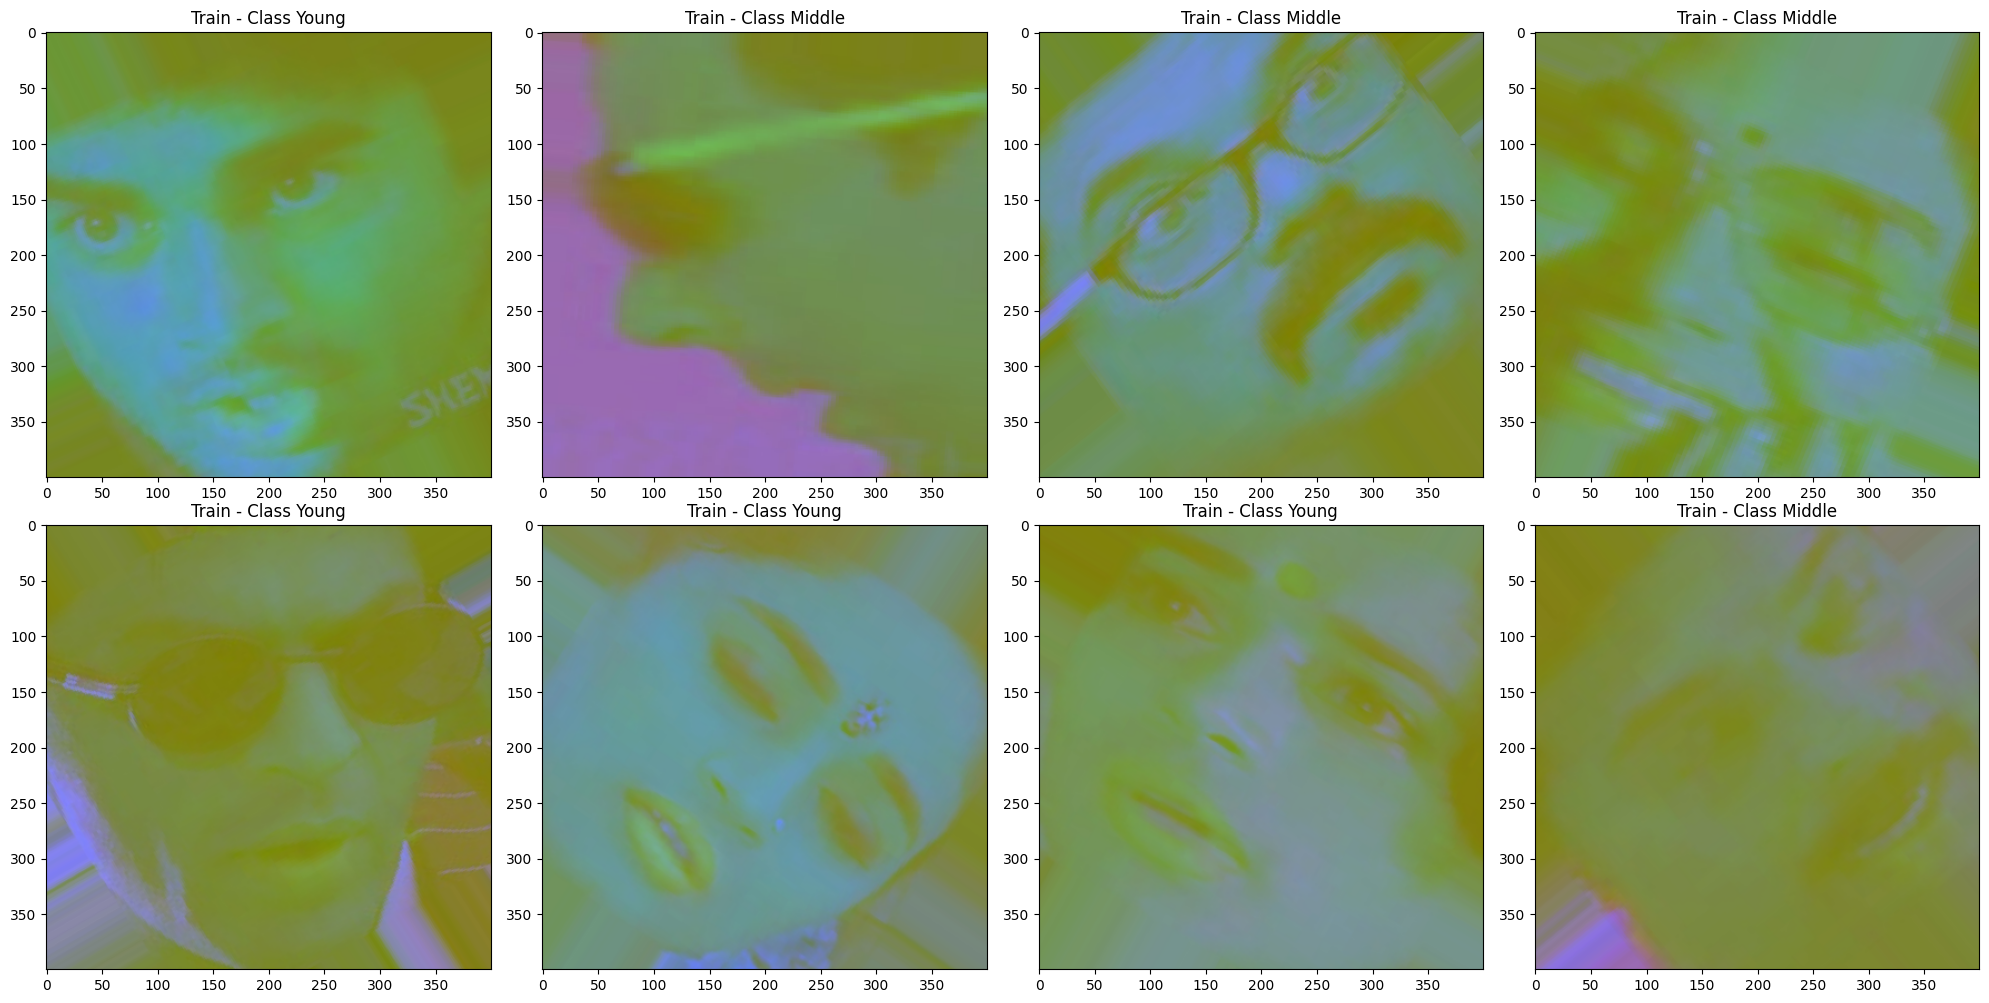

In [25]:
# Menunjukkan sample gambar pada train-set.

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
random_indices = random.sample(range(len(train)), 8)
for i, idx in enumerate(random_indices):
    image, label = train[idx]
    class_name = list(train.class_indices.keys())[int(label[0])]
    ax[i//4, i%4].imshow(image[0])
    ax[i//4, i%4].set_title(f'Train - Class {class_name}')
plt.tight_layout()
plt.show()

# D. ANN Training

Pada tahap ini saya akan melakukan ANN training dengan Sequential API, dan nantinya akan dilakukan improvement pada tahap selanjutnya untuk mencari nilai akurasi dan fitting yang lebih baik.



## Model Definition

In [26]:
# Melakukan clear session.
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [27]:
# Sequential API
# Mendefinisikan arsitektur model.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Melakukan kompilasi model dengan beberapa hyperparameter.
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 614656)            0         
                                                                 
 dense (Dense)               (None, 64)                3

In [28]:
# Reinstall necessary packages.
!pip install pydot
!pip install graphviz
!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


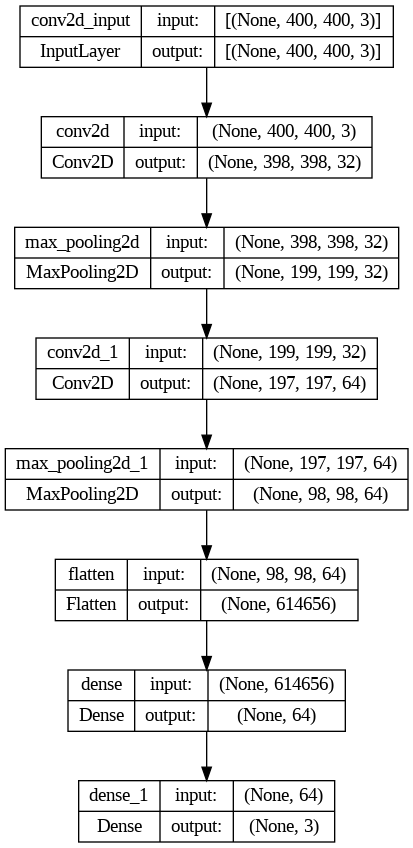

In [29]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Model Training

In [30]:
%%time

# Melakukan pelatihan base model.
history = model.fit(train,
                    epochs=21,
                    validation_data=val,
                    batch_size=64)

Epoch 1/21
115/115 [==============================] - 258s 2s/step - loss: 1.5293 - accuracy: 0.5287 - val_loss: 0.9018 - val_accuracy: 0.5965
Epoch 2/21
115/115 [==============================] - 251s 2s/step - loss: 0.8785 - accuracy: 0.6092 - val_loss: 0.8553 - val_accuracy: 0.6014
Epoch 3/21
115/115 [==============================] - 250s 2s/step - loss: 0.8511 - accuracy: 0.6144 - val_loss: 0.8686 - val_accuracy: 0.6030
Epoch 4/21
115/115 [==============================] - 248s 2s/step - loss: 0.8482 - accuracy: 0.6226 - val_loss: 0.8897 - val_accuracy: 0.6006
Epoch 5/21
115/115 [==============================] - 251s 2s/step - loss: 0.8430 - accuracy: 0.6259 - val_loss: 0.8395 - val_accuracy: 0.6289
Epoch 6/21
115/115 [==============================] - 251s 2s/step - loss: 0.8369 - accuracy: 0.6308 - val_loss: 0.8472 - val_accuracy: 0.6260
Epoch 7/21
115/115 [==============================] - 253s 2s/step - loss: 0.8393 - accuracy: 0.6284 - val_loss: 0.8334 - val_accuracy: 0.6141

## Model Evaluation

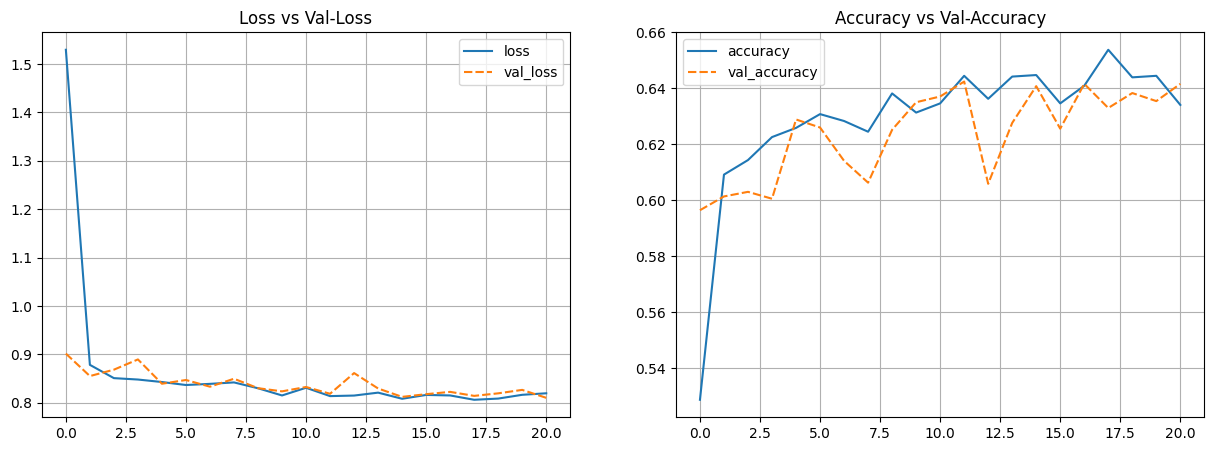

In [31]:
# Melakukan plot grafik akurasi dan loss pada tiap epoch.

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [32]:
# Memunculkan nilai evaluasi akurasi pada data test.
test_loss, test_acc = model.evaluate(test)
print(f'Test accuracy: {test_acc}')

96/96 [==============================] - 52s 536ms/step - loss: 0.7863 - accuracy: 0.6596
Test accuracy: 0.6596059203147888


# E. ANN Improvement

Di tahap ini saya ingin melakukan improvement dengan arsitektur ANN yang berbeda dari sebelumnya, dimana saya menambahkan beberapa layer convolutional dan penambahan layer dense. Dengan harapan mendapatkan hasil akurasi dan fitting yang lebih baik (performansi yang lebih baik).

## Model Definition

In [33]:
# Melakukan clear session.
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [34]:
# Sequential API
# Melakukan definisi arsitektural model improvement.
model_improve = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

# Melakukan kompilasi model improvement dengan berbagai hyperparameter.
model_improve.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_improve.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 128)       0

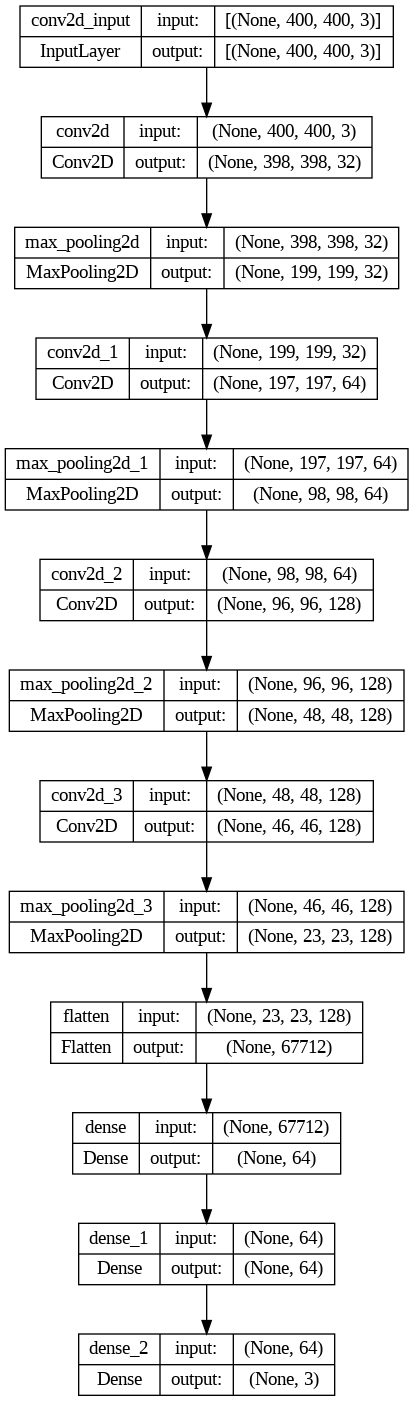

In [35]:
tf.keras.utils.plot_model(model_improve, show_shapes=True)

## Model Training

In [36]:
%%time

# Melakukan pelatihan model improvement.
history_improve = model_improve.fit(train,
                    epochs=21,
                    validation_data=val,
                    batch_size=64)

Epoch 1/21
115/115 [==============================] - 262s 2s/step - loss: 0.9618 - accuracy: 0.4926 - val_loss: 1.1060 - val_accuracy: 0.4758
Epoch 2/21
115/115 [==============================] - 260s 2s/step - loss: 0.9182 - accuracy: 0.5624 - val_loss: 0.8771 - val_accuracy: 0.6010
Epoch 3/21
115/115 [==============================] - 262s 2s/step - loss: 0.8541 - accuracy: 0.6245 - val_loss: 0.8567 - val_accuracy: 0.6137
Epoch 4/21
115/115 [==============================] - 261s 2s/step - loss: 0.8400 - accuracy: 0.6226 - val_loss: 0.8425 - val_accuracy: 0.6293
Epoch 5/21
115/115 [==============================] - 263s 2s/step - loss: 0.8338 - accuracy: 0.6278 - val_loss: 0.8396 - val_accuracy: 0.6273
Epoch 6/21
115/115 [==============================] - 260s 2s/step - loss: 0.8414 - accuracy: 0.6278 - val_loss: 0.8198 - val_accuracy: 0.6310
Epoch 7/21
115/115 [==============================] - 262s 2s/step - loss: 0.8153 - accuracy: 0.6437 - val_loss: 0.8320 - val_accuracy: 0.6305

## Model Evaluation

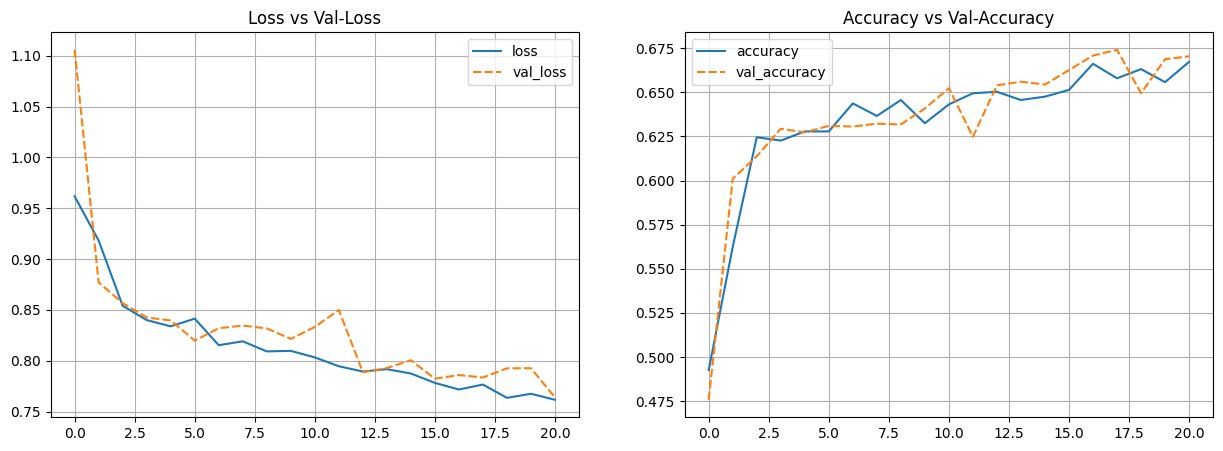

In [37]:
# Memunculkan plot grafik akurasi dan loss hasil pelatihan model improvement.

history_imp_df = pd.DataFrame(history_improve.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_imp_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_imp_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

In [38]:
# Melakukan evaluasi dan menampilkan nilai akurasi model improvement terhadap data test.
test_loss, test_acc = model_improve.evaluate(test)
print(f'Test accuracy ANN Improvement: {test_acc}')

96/96 [==============================] - 56s 576ms/step - loss: 0.7182 - accuracy: 0.6869
Test accuracy ANN Improvement: 0.6868637204170227


# F. Best Model Saving

Meskipun dari hasil analisa grafik `model improvement` masih memiliki sedikit overfitting, namun memiliki nilai akurasi yang jauh lebih baik dibandingkan `base model` (memiliki selisih ~3%) dan grafik akurasi yang lebih konsisten. Maka setelah melakukan berkali-kali percobaan untuk mencari peningkatan model dari segi perfomansi, saya memilih `model improvement` ini untuk menjadi model yang disimpan.

In [39]:
# Menyimpan model improvement (best model) ke dalam direktori google drive.
model_improve.save('/content/drive/MyDrive/best_ann_model.keras')

# Conclusion

## EDA Recap

Karakteristik utama pada dataset:


1. Gambar terbagi atas tiga class (Young, Middle, dan Old).
2. Gambar pada dataset sudah terpotong atau terfokus hanya pada wajah saja.
3. Ada beberapa gambar yang memiliki resolusi rendah (tidak layak).
4. Ada juga beberapa gambar yang berwarna hitam dan putih.
5. Dikarenakan gambar diambil dari para selebritis India, maka karakteristik wajah dan warna kulit mereka adalah sawo matang/putih.
6. Beberapa wajah memiliki riasan/atribut yang menutupi wajah, seperti riasan acara ibadah, anting pada hidung, kacamata, surban, dan lain sebagainya.
7. Mayoritas gambar pada tiap class memiliki sudut foto yang tidak beraturan (menghadap samping, bawah, atau atas)
8. Dari beberapa referensi yang saya baca (link terlampir pada bagian EDA), bahwa untuk melakukan deep learning pada wajah manusia lebih optimal ketika ruang warna di ubah menjadi YCbCr.



## Model Recap

Terlihat dari hasil analisa pemodelan bahwa `model improvement` dengan arsitektur:

```
model_improve = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
```

Memiliki hasil akurasi yang lebih baik dibandingkan dengan base model (memiliki tingkat akurasi ~3% lebih baik) dan grafik akurasi yang lebih konsisten. Sedangkan untuk kelemahan `model improvement` yang saya gunakan adalah masih mengalami sedikit overfitting dan dalam melakukan pelatihan jauh lebih memakan waktu dibandingkan saat melakukan pelatihan base model.

-

Penyusunan `model improvement` terinspirasi dari arsitektur `VGG16`, yang mana biasa digunakan untuk melakukan deep learning pada wajah manusia. Arsitektur `VGG16` sebagai berikut:

```
Input (224x224x3)

[Conv2D (64 filters, 3x3), ReLU]
[Conv2D (64 filters, 3x3), ReLU]
MaxPooling2D (2x2)

[Conv2D (128 filters, 3x3), ReLU]
[Conv2D (128 filters, 3x3), ReLU]
MaxPooling2D (2x2)

[Conv2D (256 filters, 3x3), ReLU]
[Conv2D (256 filters, 3x3), ReLU]
[Conv2D (256 filters, 3x3), ReLU]
MaxPooling2D (2x2)

[Conv2D (512 filters, 3x3), ReLU]
[Conv2D (512 filters, 3x3), ReLU]
[Conv2D (512 filters, 3x3), ReLU]
MaxPooling2D (2x2)

[Conv2D (512 filters, 3x3), ReLU]
[Conv2D (512 filters, 3x3), ReLU]
[Conv2D (512 filters, 3x3), ReLU]
MaxPooling2D (2x2)

Flatten
Dense (4096 units, ReLU)
Dense (4096 units, ReLU)
Dense (num_classes units, Softmax)

```

Namun pada program ini saya tidak melakukan transfer learning, dikarenakan keterbatasan waktu dan kemampuan hardware yang saya miliki.



